In [1]:
pip install codecarbon

  Using cached codecarbon-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached pynvml-11.5.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached rapidfuzz-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached codecarbon-2.4.1-py3-none-any.whl (491 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
Using cached pynvml-11.5.0-py3-none-any.whl (53 kB)
Using cached rapidfuzz-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd
from codecarbon import OfflineEmissionsTracker

2024-05-17 14:04:13.182561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 14:04:30.065210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load li

In [3]:
training_set=tf.data.Dataset.load('gs://plant_buddy2/oxford_dataset/training_set')
validation_set=tf.data.Dataset.load('gs://plant_buddy2/oxford_dataset/validation_set')
test_set=tf.data.Dataset.load('gs://plant_buddy2/oxford_dataset/test_set')

training_class_counts = {}
validation_class_counts = {}
test_class_counts = {}

for images, labels in training_set:
    for label in labels.numpy():
        label = label.item() 
        if label in training_class_counts:
            training_class_counts[label] += 1
        else:
            training_class_counts[label] = 1

for images, labels in validation_set:
    for label in labels.numpy():
        label = label.item() 
        if label in validation_class_counts:
            validation_class_counts[label] += 1
        else:
            validation_class_counts[label] = 1

for images, labels in test_set:
    for label in labels.numpy():
        label = label.item() 
        if label in test_class_counts:
            test_class_counts[label] += 1
        else:
            test_class_counts[label] = 1


In [3]:
training_set_original=tf.data.Dataset.load('gs://plant_buddy2/oxoford_dataset_original/training_set_original')
validation_set_original=tf.data.Dataset.load('gs://plant_buddy2/oxoford_dataset_original/validation_set_original')
test_set_original=tf.data.Dataset.load('gs://plant_buddy2/oxoford_dataset_original/test_set_original')

training_class_counts = {}
validation_class_counts = {}
test_class_counts = {}

for images, labels in training_set_original:
    for label in labels.numpy():
        label = label.item()  
        if label in training_class_counts:
            training_class_counts[label] += 1
        else:
            training_class_counts[label] = 1

for images, labels in validation_set_original:
    for label in labels.numpy():
        label = label.item()  
        if label in validation_class_counts:
            validation_class_counts[label] += 1
        else:
            validation_class_counts[label] = 1

for images, labels in test_set_original:
    for label in labels.numpy():
        label = label.item()
        if label in test_class_counts:
            test_class_counts[label] += 1
        else:
            test_class_counts[label] = 1

In [7]:
total_training_examples = sum(training_class_counts.values())
average_examples_per_class = total_training_examples / len(training_class_counts)

print("Average number of examples per class in the training set:", average_examples_per_class)

Average number of examples per class in the training set: 64.23529411764706


In [10]:
above_average_count = 0
under_average_count = 0

for count in training_class_counts.values():
    if count >= average_examples_per_class:
        above_average_count += 1
    elif count < average_examples_per_class:
        under_average_count += 1

print("Number of classes with examples above average:", above_average_count)
print("Number of classes with examples under average:", under_average_count)

Number of classes with examples above average: 37
Number of classes with examples under average: 65


In [11]:
classes_above_average = [label for label, count in training_class_counts.items() if count > average_examples_per_class]
above_average_training_set = training_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, classes_above_average)))
above_average_validation_set = validation_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, classes_above_average)))
above_average_test_set = test_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, classes_above_average)))

In [20]:
print(classes_above_average)

[72, 95, 43, 93, 88, 11, 59, 64, 55, 81, 76, 22, 75, 42, 74, 94, 7, 73, 80, 29, 97, 82, 87, 50, 45, 36, 52, 49, 57, 16, 71, 40, 79, 83, 10, 77, 51]


In [ ]:
classes_above_average_tensor = tf.constant(classes_above_average)
def filter_batches(images, labels):
    mask = tf.reduce_any(tf.equal(tf.expand_dims(labels, axis=-1), classes_above_average_tensor), axis=-1)
    return tf.boolean_mask(images, mask), tf.boolean_mask(labels, mask)

above_average_training_set = training_set.map(filter_batches)
above_average_validation_set = validation_set.map(filter_batches)
above_average_test_set = test_set.map(filter_batches)

def print_dataset(dataset, dataset_name):
    print(f"Printing {dataset_name}:")
    for images, labels in dataset:
        print(f"Labels: {labels.numpy()}, Images: {images.numpy()}") 

print_dataset(above_average_training_set, "Above Average Training Set")
print_dataset(above_average_validation_set, "Above Average Validation Set")
print_dataset(above_average_test_set, "Above Average Test Set")

In [ ]:
above_average_training_class_counts = {}
above_average_validation_class_counts = {}
above_average_test_class_counts = {}

for images, labels in above_average_training_set:
    for label in labels.numpy():
        label = label.item()
        if label in above_average_training_class_counts:
            above_average_training_class_counts[label] += 1
        else:
            above_average_training_class_counts[label] = 1

for images, labels in above_average_validation_set:
    for label in labels.numpy():
        label = label.item()  
        if label in above_average_validation_class_counts:
            above_average_validation_class_counts[label] += 1
        else:
            above_average_validation_class_counts[label] = 1

for images, labels in above_average_test_set:
    for label in labels.numpy():
        label = label.item() 
        if label in above_average_test_class_counts:
            above_average_test_class_counts[label] += 1
        else:
            above_average_test_class_counts[label] = 1

In [ ]:
def print_dataset(dataset, dataset_name):
    print(f"Printing {dataset_name}:")
    for images, labels in dataset:
        print(f"Label: {labels.numpy()}, Images: {images.numpy()}") 

print_dataset(above_average_training_set, "Above Average Training Set")
print_dataset(above_average_validation_set, "Above Average Validation Set")
print_dataset(above_average_test_set, "Above Average Test Set")

In [ ]:
common_labels = set(above_average_training_class_counts.keys()) & set(above_average_validation_class_counts.keys()) & set(above_average_test_class_counts.keys())

above_average_training_set = above_average_training_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, list(common_labels))))
above_average_validation_set = above_average_validation_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, list(common_labels))))
above_average_test_set = above_average_test_set.filter(lambda images, labels: tf.reduce_any(tf.equal(labels, list(common_labels))))

def print_dataset(dataset, dataset_name):
    print(f"Printing {dataset_name}:")
    for images, labels in dataset:
        print(f"Label: {labels.numpy()}, Images: {images.numpy()}")  

print_dataset(above_average_training_set, "Above Average Training Set")
print_dataset(above_average_validation_set, "Above Average Validation Set")
print_dataset(above_average_test_set, "Above Average Test Set")

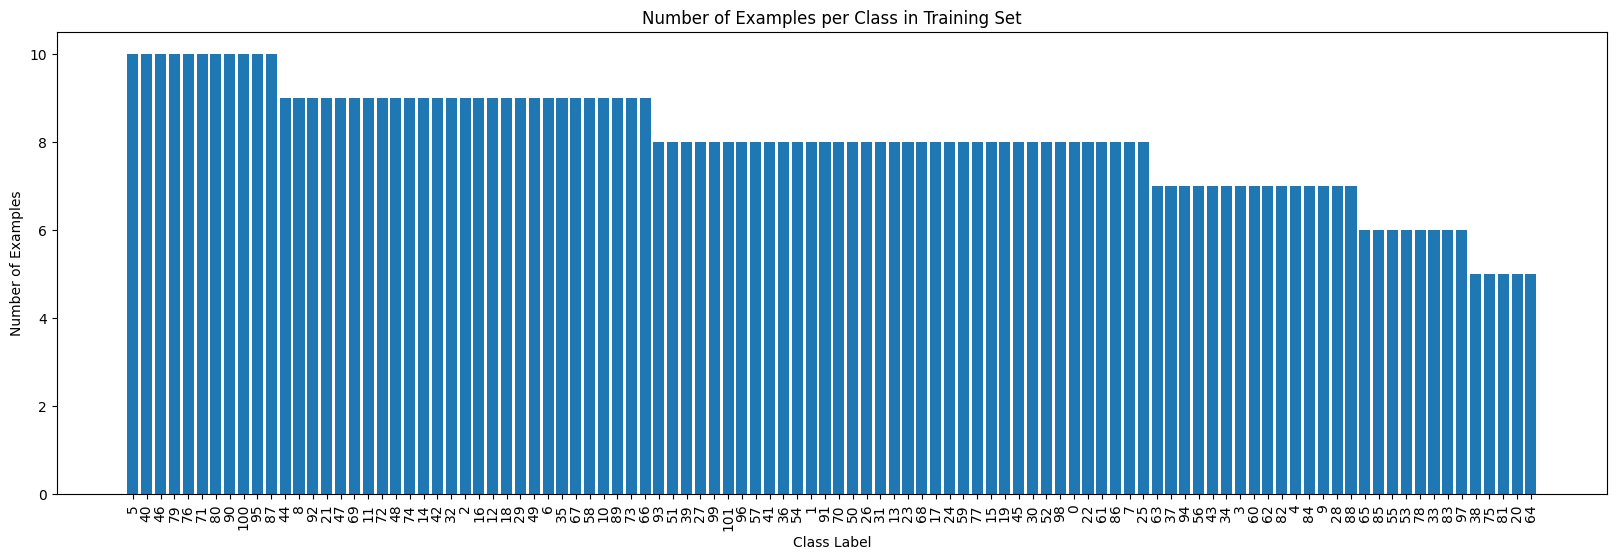

In [16]:
sorted_classes = sorted(validation_class_counts.keys(), key=lambda x: validation_class_counts[x], reverse=True)

plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_classes)), [validation_class_counts[label] for label in sorted_classes], align='center')
plt.xticks(range(len(sorted_classes)), [str(label) for label in sorted_classes], rotation='vertical')
plt.ylabel('Number of Examples')
plt.xlabel('Class Label')
plt.title('Number of Examples per Class in Training Set')
plt.show()


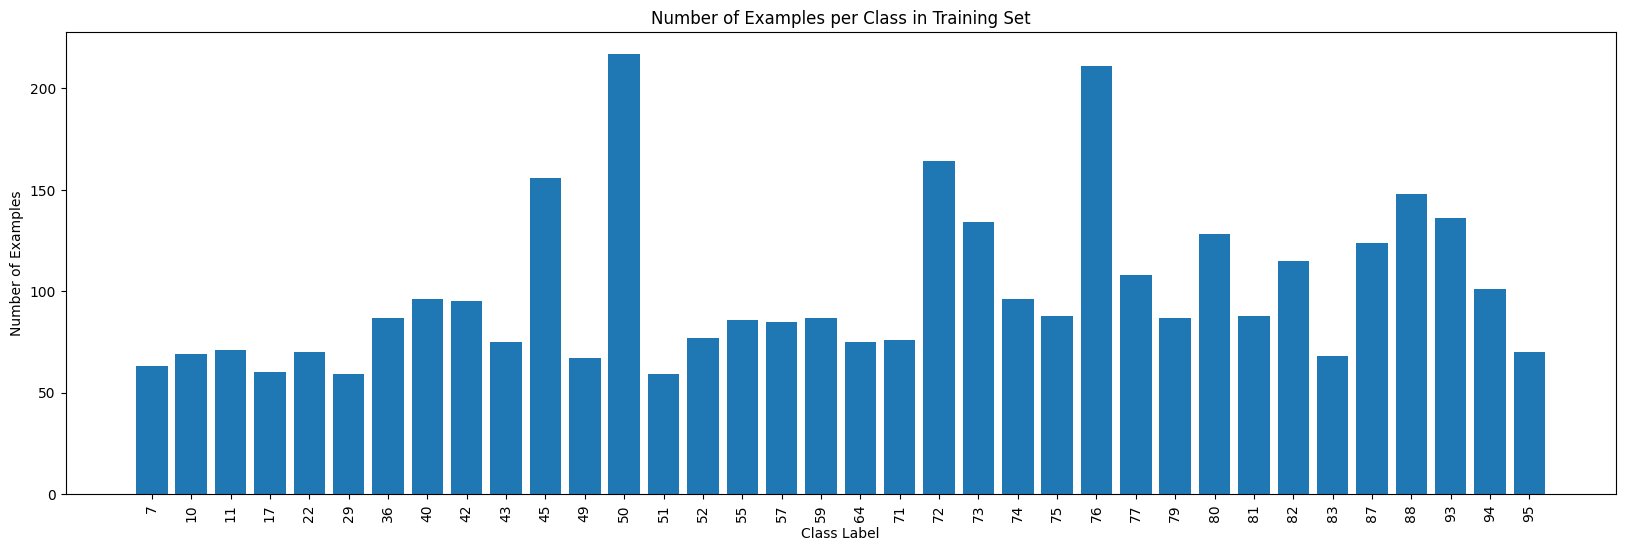

In [14]:
sorted_classes = sorted(training_class_counts.keys())

plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_classes)), [training_class_counts[label] for label in sorted_classes], align='center')
plt.xticks(range(len(sorted_classes)), [str(label) for label in sorted_classes], rotation='vertical')
plt.ylabel('Number of Examples')
plt.xlabel('Class Label')
plt.title('Number of Examples per Class in Training Set')
plt.show()

In [4]:
print("Training set labels:")
for label, count in training_class_counts.items():
    print("{}".format(label))

print("Training set:")
for label, count in training_class_counts.items():
    print("{}".format(count))

print("\nValidation set labels:")
for label, count in validation_class_counts.items():
    print("{}".format(label))

print("\nValidation set:")
for label, count in validation_class_counts.items():
    print("{}".format(count))

print("\nTest set labels:")
for label, count in test_class_counts.items():
    print("{}".format(label))

print("\nTest set:")
for label, count in test_class_counts.items():
    print("{}".format(count))

Training set labels:
25
100
66
17
72
95
43
26
93
88
23
11
90
28
59
64
68
55
69
81
78
70
6
14
12
19
27
3
76
22
56
75
42
74
5
94
7
33
38
73
34
35
18
80
29
97
84
60
82
63
2
86
65
15
87
20
47
50
4
46
45
89
21
0
36
52
49
61
57
24
16
99
85
54
48
71
40
79
83
1
96
92
101
10
77
91
32
41
98
8
62
51
53
67
31
58
39
30
13
37
44
9
Training set:
27
46
30
62
166
70
77
26
143
158
31
73
60
61
90
86
41
86
46
94
27
64
27
36
35
43
49
44
217
74
53
89
116
101
30
107
69
29
29
151
33
57
34
137
67
68
46
32
106
38
29
50
49
31
131
28
57
228
53
54
167
64
46
28
89
73
76
45
97
29
66
33
46
54
37
76
106
88
70
47
49
32
38
70
118
50
33
44
51
33
41
68
48
41
35
52
51
36
32
42
28
32

Validation set labels:
44
8
65
93
92
5
40
85
63
51
46
39
38
21
27
47
99
75
101
37
96
69
11
72
48
74
14
55
57
79
42
76
41
36
54
32
71
94
1
91
53
80
70
50
56
43
34
26
31
3
2
60
81
16
12
78
13
23
62
82
18
68
17
29
49
4
24
59
77
90
100
15
19
6
45
33
35
95
30
84
67
83
97
87
58
52
20
9
28
98
0
22
61
86
88
10
89
64
7
73
66
25

Validation set:
9
9
6
8

In [9]:
num_training_batches = tf.data.experimental.cardinality(training_set).numpy()
num_validation_batches = tf.data.experimental.cardinality(validation_set).numpy()
num_test_batches = tf.data.experimental.cardinality(test_set).numpy()

print("Number of batches in the training set:", num_training_batches)
print("Number of batches in the validation set:", num_validation_batches)
print("Number of batches in the test set:", num_test_batches)

Number of batches in the training set: 113
Number of batches in the validation set: 16
Number of batches in the test set: 15


In [24]:
# input_shape = (224, 224, 3)
model_above = tf.keras.models.load_model('gs://plant_buddy2/models/model_flower1', compile=False)

# # model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
base_learning_rate = 0.0001
model_above.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy']) 

model_above.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [16]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Reshape
from tensorflow.keras import layers, Sequential

input_shape = (224, 224, 3)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4),
])

def tensorflow_based_model():
    model = Sequential() 
    
    model.add(data_augmentation) 
    
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(224,224,3), padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2)) 

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2))  
    
    model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2))  
    
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    # model.add(MaxPooling2D(pool_size=2))  
    
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    # model.add(MaxPooling2D(pool_size=2))  
    
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'))  
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2))  
    
    model.add(Conv2D(filters=256, kernel_size=2, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2)) 
    
    model.add(Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2)) 
        
    model.add(Conv2D(filters=256, kernel_size=2, activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=2)) 

    model.add(Dropout(0.2))  
    model.add(Flatten())  
    model.add(Dense(150))  
    model.add(Activation('relu'))  
    model.add(Dropout(0.2))  
    model.add(Dense(102, activation='softmax'))  

    return model

In [17]:
model_above = tensorflow_based_model()
# model = tf.keras.models.load_model('gs://plant_buddy2/models/model12_wd_dr', compile=False)
# wd=0.0001
base_learning_rate = 0.001
# model_above.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_above.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy']) 

In [ ]:
# model = tf.keras.models.load_model('gs://plant_buddy2/models/model12_9conv17_re5_4_2', compile=False)

# # model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
# base_learning_rate = 0.00004
# model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate), metrics=['accuracy']) 

# tracker = OfflineEmissionsTracker(country_iso_code="USA", measure_power_secs=600, output_dir="gs://plant_buddy2/energy", output_file="emissions12_9above17_2_2.csv")
# tracker.start()

# history = model_above.fit(training_set,
#         batch_size = 32,
#         epochs=200,
#         validation_data=validation_set)

# emissions: float = tracker.stop()
# print(emissions)

# model_above.save('gs://plant_buddy2/models/model12_9above17_2_2')
# pd.DataFrame.from_dict(history.history).to_csv('gs://plant_buddy2/histories/history12_9above17_2_2.csv',index=False)
#######################
# model = tf.keras.models.load_model('gs://plant_buddy2/models/model12_9conv17_re5', compile=False)

# # model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
# base_learning_rate = 0.0001
# model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy']) 

# model = tensorflow_based_model()
# model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
tracker = OfflineEmissionsTracker(country_iso_code="USA", measure_power_secs=600, output_dir="gs://plant_buddy2/energy", output_file="emissions_flower2.csv")
tracker.start()

history = model_above.fit(training_set,
        batch_size = 32,
        epochs=50,
        validation_data=validation_set)

emissions: float = tracker.stop()
print(emissions)

model_above.save('gs://plant_buddy2/models/model_flower2')
pd.DataFrame.from_dict(history.history).to_csv('gs://plant_buddy2/histories/history_flower2.csv',index=False)
# ######################
# model = tf.keras.models.load_model('gs://plant_buddy2/models/model12_9conv17_re5_ad1', compile=False)

# # model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
# base_learning_rate = 0.00001
# model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy']) 

# tracker = OfflineEmissionsTracker(country_iso_code="USA", measure_power_secs=600, output_dir="gs://plant_buddy2/energy", output_file="emissions12_9conv17_re5_ad2.csv")
# tracker.start()

# history = model.fit(training_set,
#         batch_size = 32,
#         epochs=100,
#         validation_data=validation_set)

# emissions: float = tracker.stop()
# print(emissions)

# model.save('gs://plant_buddy2/models/model12_9conv17_re5_ad2')
# pd.DataFrame.from_dict(history.history).to_csv('gs://plant_buddy2/histories/history12_9conv17_re5_ad2.csv',index=False)

[codecarbon INFO @ 18:35:17] offline tracker init
[codecarbon WARNING @ 18:35:17] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 18:35:17] [setup] RAM Tracking...
[codecarbon INFO @ 18:35:17] [setup] GPU Tracking...
[codecarbon INFO @ 18:35:17] No GPU found.
[codecarbon INFO @ 18:35:17] [setup] CPU Tracking...
[codecarbon WARNING @ 18:35:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:35:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 18:35:19] >>> Tracker's metadata:
[codecarbon INFO @ 18:35:19]   Platform system: Linux-5.10.0-28-cloud-amd64-x86_64-with-glibc2.35
[codecarbon INFO @ 18:35:19]   Python version: 3.10.13
[codecarbon INFO @ 18:35:19]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 18:35:19]   Available RAM : 29.390 GB
[codecarbon INFO @ 18:35:19]   CPU count: 8
[codecarbon INFO @ 18:35:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 18:3

Epoch 1/50
205/205 [==============================] - 93s 444ms/step - loss: 0.1541 - accuracy: 0.9512 - val_loss: 2.3939 - val_accuracy: 0.7131
Epoch 2/50
205/205 [==============================] - 92s 446ms/step - loss: 0.1269 - accuracy: 0.9585 - val_loss: 2.4170 - val_accuracy: 0.7216
Epoch 3/50
205/205 [==============================] - 91s 440ms/step - loss: 0.1330 - accuracy: 0.9567 - val_loss: 2.4203 - val_accuracy: 0.7155
Epoch 4/50
205/205 [==============================] - 91s 441ms/step - loss: 0.1147 - accuracy: 0.9629 - val_loss: 2.4248 - val_accuracy: 0.7326
Epoch 5/50
205/205 [==============================] - 90s 439ms/step - loss: 0.1148 - accuracy: 0.9631 - val_loss: 2.3858 - val_accuracy: 0.7241
Epoch 6/50
205/205 [==============================] - 92s 443ms/step - loss: 0.1143 - accuracy: 0.9614 - val_loss: 2.4408 - val_accuracy: 0.7241
Epoch 7/50
119/205 [================>.............] - ETA: 35s - loss: 0.1055 - accuracy: 0.9645

[codecarbon INFO @ 18:45:19] Energy consumed for RAM : 0.001837 kWh. RAM Power : 11.021209716796875 W
[codecarbon INFO @ 18:45:19] Energy consumed for all CPUs : 0.005083 kWh. Total CPU Power : 30.5 W
[codecarbon INFO @ 18:45:19] 0.006920 kWh of electricity used since the beginning.


205/205 [==============================] - 90s 436ms/step - loss: 0.1011 - accuracy: 0.9675 - val_loss: 2.4506 - val_accuracy: 0.7338
Epoch 8/50
205/205 [==============================] - 91s 439ms/step - loss: 0.1061 - accuracy: 0.9654 - val_loss: 2.4423 - val_accuracy: 0.7338
Epoch 9/50
205/205 [==============================] - 90s 436ms/step - loss: 0.0982 - accuracy: 0.9676 - val_loss: 2.3818 - val_accuracy: 0.7436
Epoch 10/50
205/205 [==============================] - 91s 439ms/step - loss: 0.1071 - accuracy: 0.9635 - val_loss: 2.4451 - val_accuracy: 0.7289
Epoch 11/50
205/205 [==============================] - 92s 443ms/step - loss: 0.0943 - accuracy: 0.9708 - val_loss: 2.4736 - val_accuracy: 0.7302
Epoch 12/50
205/205 [==============================] - 92s 444ms/step - loss: 0.0972 - accuracy: 0.9675 - val_loss: 2.5778 - val_accuracy: 0.7375
Epoch 13/50
205/205 [==============================] - 91s 439ms/step - loss: 0.0937 - accuracy: 0.9701 - val_loss: 2.5318 - val_accuracy:

[codecarbon INFO @ 18:55:19] Energy consumed for RAM : 0.003674 kWh. RAM Power : 11.021209716796875 W
[codecarbon INFO @ 18:55:19] Energy consumed for all CPUs : 0.010167 kWh. Total CPU Power : 30.5 W
[codecarbon INFO @ 18:55:19] 0.013841 kWh of electricity used since the beginning.


205/205 [==============================] - 89s 433ms/step - loss: 0.0964 - accuracy: 0.9693 - val_loss: 2.5095 - val_accuracy: 0.7265
Epoch 15/50
205/205 [==============================] - 90s 439ms/step - loss: 0.0931 - accuracy: 0.9707 - val_loss: 2.5444 - val_accuracy: 0.7375
Epoch 16/50
205/205 [==============================] - 90s 435ms/step - loss: 0.0912 - accuracy: 0.9715 - val_loss: 2.4698 - val_accuracy: 0.7399
Epoch 17/50
205/205 [==============================] - 90s 437ms/step - loss: 0.0816 - accuracy: 0.9725 - val_loss: 2.4706 - val_accuracy: 0.7375
Epoch 18/50
205/205 [==============================] - 93s 450ms/step - loss: 0.0895 - accuracy: 0.9731 - val_loss: 2.4555 - val_accuracy: 0.7399
Epoch 19/50
205/205 [==============================] - 91s 440ms/step - loss: 0.0881 - accuracy: 0.9724 - val_loss: 2.4787 - val_accuracy: 0.7387
Epoch 20/50
170/205 [=======================>......] - ETA: 14s - loss: 0.0894 - accuracy: 0.9726

[codecarbon INFO @ 19:05:19] Energy consumed for RAM : 0.005511 kWh. RAM Power : 11.021209716796875 W
[codecarbon INFO @ 19:05:19] Energy consumed for all CPUs : 0.015250 kWh. Total CPU Power : 30.5 W
[codecarbon INFO @ 19:05:19] 0.020761 kWh of electricity used since the beginning.


205/205 [==============================] - 90s 438ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 2.4963 - val_accuracy: 0.7338
Epoch 21/50
205/205 [==============================] - 90s 437ms/step - loss: 0.0853 - accuracy: 0.9731 - val_loss: 2.5780 - val_accuracy: 0.7326
Epoch 22/50
205/205 [==============================] - 92s 442ms/step - loss: 0.0925 - accuracy: 0.9693 - val_loss: 2.5313 - val_accuracy: 0.7289
Epoch 23/50
205/205 [==============================] - 90s 437ms/step - loss: 0.0861 - accuracy: 0.9716 - val_loss: 2.5326 - val_accuracy: 0.7363
Epoch 24/50
205/205 [==============================] - 91s 440ms/step - loss: 0.0803 - accuracy: 0.9730 - val_loss: 2.6162 - val_accuracy: 0.7375
Epoch 25/50
205/205 [==============================] - 91s 439ms/step - loss: 0.0813 - accuracy: 0.9748 - val_loss: 2.6164 - val_accuracy: 0.7326
Epoch 26/50
205/205 [==============================] - 91s 444ms/step - loss: 0.0820 - accuracy: 0.9742 - val_loss: 2.5732 - val_accurac

[codecarbon INFO @ 19:15:19] Energy consumed for RAM : 0.007347 kWh. RAM Power : 11.021209716796875 W
[codecarbon INFO @ 19:15:19] Energy consumed for all CPUs : 0.020333 kWh. Total CPU Power : 30.5 W
[codecarbon INFO @ 19:15:19] 0.027681 kWh of electricity used since the beginning.


205/205 [==============================] - 92s 444ms/step - loss: 0.0783 - accuracy: 0.9733 - val_loss: 2.6725 - val_accuracy: 0.7326
Epoch 28/50
205/205 [==============================] - 91s 440ms/step - loss: 0.0834 - accuracy: 0.9741 - val_loss: 2.5398 - val_accuracy: 0.7448
Epoch 29/50
205/205 [==============================] - 91s 441ms/step - loss: 0.0772 - accuracy: 0.9734 - val_loss: 2.6437 - val_accuracy: 0.7338
Epoch 30/50
205/205 [==============================] - 92s 443ms/step - loss: 0.0786 - accuracy: 0.9731 - val_loss: 2.5846 - val_accuracy: 0.7350
Epoch 31/50
205/205 [==============================] - 94s 456ms/step - loss: 0.0886 - accuracy: 0.9731 - val_loss: 2.6408 - val_accuracy: 0.7265
Epoch 32/50
205/205 [==============================] - 91s 443ms/step - loss: 0.0723 - accuracy: 0.9753 - val_loss: 2.6967 - val_accuracy: 0.7326
Epoch 33/50
200/205 [============================>.] - ETA: 2s - loss: 0.0729 - accuracy: 0.9766

[codecarbon INFO @ 19:25:19] Energy consumed for RAM : 0.009184 kWh. RAM Power : 11.021209716796875 W
[codecarbon INFO @ 19:25:19] Energy consumed for all CPUs : 0.025417 kWh. Total CPU Power : 30.5 W
[codecarbon INFO @ 19:25:19] 0.034601 kWh of electricity used since the beginning.


205/205 [==============================] - 91s 444ms/step - loss: 0.0730 - accuracy: 0.9766 - val_loss: 2.7098 - val_accuracy: 0.7289
Epoch 34/50
205/205 [==============================] - 91s 439ms/step - loss: 0.0743 - accuracy: 0.9762 - val_loss: 2.6536 - val_accuracy: 0.7436
Epoch 35/50
205/205 [==============================] - 92s 445ms/step - loss: 0.0737 - accuracy: 0.9760 - val_loss: 2.7150 - val_accuracy: 0.7289
Epoch 36/50
205/205 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9757

In [ ]:
tracker = OfflineEmissionsTracker(country_iso_code="USA", measure_power_secs=30, output_dir="gs://plant_buddy/energy", output_file="emissions12_8conv_17_re_eval.csv")
tracker.start()

loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

emissions: float = tracker.stop()
print(emissions)